# Motor Imagery Deep Learning project <br>
By: James McIntyre and John McLinden

In [2]:
# imports
import os
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import layers, losses
import mne 
mne.utils.set_config('MNE_USE_CUDA', 'true')  
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale, LabelBinarizer
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load data
Load saved epochs and labels from preprocessing step

In [3]:
filepath = os.getcwd()

data = np.load(filepath + '\\Data_For_James\\preprocessedOnlineDataset_EpochsAndLabels.npz')
x_train = np.transpose(data['training_epochs'],axes=[0,2,1])
x_test = np.transpose(data['testing_epochs'],axes=[0,2,1])
y_train = data['training_labels']
y_test = data['testing_labels']

Create one-hot encoding for labels

In [4]:
lb = LabelBinarizer().fit(["Right", "Left", "Feet", "Tongue"])

y_test_valid_OH = lb.transform(y_test)
y_train_OH = lb.transform(y_train)

Reshape data then apply MinMax scaling, in the same way that the CNN was trained

In [5]:
# Reshape for scaling
x_train_reshapedForScaling = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_valid_reshapedForScaling = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

In [6]:
# Scale train and test separately
x_train_scaled = minmax_scale(x_train_reshapedForScaling, axis=2)
x_test_valid_scaled = minmax_scale(x_test_valid_reshapedForScaling, axis=2)

In [7]:
# Reshape after scaling
x_test_valid_reshaped = x_test_valid_scaled.reshape(x_test_valid_scaled.shape[0], int(x_test_valid_scaled.shape[1]/2),2).astype(np.float64)

Create Val/Test split from test dataset

In [8]:
#Create Validation/test
x_valid_reshaped, x_test_reshaped, y_valid_OH, y_test_OH = train_test_split(x_test_valid_reshaped,
                                                    y_test_valid_OH,
                                                    stratify=y_test_valid_OH,
                                                    test_size=0.50,
                                                    random_state=42)

Apply SMOTE for data augmentation<br>
Only apply to training set <br>
Does not apply for online dataset, only for the limited recorded dataset.


In [9]:
# smote
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_train_smote, y_train_OH_smote = sm.fit_resample(x_train_scaled, y_train_OH)
print('classes count')
print ('before oversampling = {}'.format(y_train_OH.sum(axis=0)))
print ('after oversampling = {}'.format(y_train_OH_smote.sum(axis=0)))

# no smote
# x_train_smote, y_train_OH_smote = x_train_scaled, y_train_OH

classes count
before oversampling = [972 972 972 972]
after oversampling = [972 972 972 972]


In [10]:
# Reshape training data after SMOTE
x_train_reshaped = x_train_smote.reshape(x_train_smote.shape[0], int(x_train_smote.shape[1]/2),2).astype(np.float64)

## Train CNN architecture on new dataset

Set up and train a CNN

In [11]:
class HopefullNet(tf.keras.Model):
    """
    Original HopeFullNet
    """
    def __init__(self, inp_shape = (640,2)):
        super(HopefullNet, self).__init__()
        self.inp_shape = inp_shape

        self.kernel_size_0 = 20
        self.kernel_size_1 = 6
        self.drop_rate = 0.5

        self.conv1 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding= "same",
                                            input_shape=self.inp_shape)
        self.batch_n_1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding= "valid")
        self.batch_n_2 = tf.keras.layers.BatchNormalization()
        self.spatial_drop_1 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.conv3 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding= "valid")
        self.avg_pool1 = tf.keras.layers.AvgPool1D(pool_size=2)
        self.conv4 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding= "valid")
        self.spatial_drop_2 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.flat = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(296, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(self.drop_rate)
        self.dense2 = tf.keras.layers.Dense(148, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(self.drop_rate)
        self.dense3 = tf.keras.layers.Dense(74, activation='relu')
        self.dropout3 = tf.keras.layers.Dropout(self.drop_rate)
        self.out = tf.keras.layers.Dense(4, activation='softmax')

    def call(self, input_tensor):
        conv1 = self.conv1(input_tensor)
        batch_n_1 = self.batch_n_1(conv1)
        conv2 = self.conv2(batch_n_1)
        batch_n_2 = self.batch_n_2(conv2)
        spatial_drop_1 = self.spatial_drop_1(batch_n_2)
        conv3 = self.conv3(spatial_drop_1)
        avg_pool1 = self.avg_pool1(conv3)
        conv4 = self.conv4(avg_pool1)
        spatial_drop_2 = self.spatial_drop_2(conv4)
        flat = self.flat(spatial_drop_2)
        dense1 = self.dense1(flat)
        dropout1 = self.dropout1(dense1)
        dense2 = self.dense2(dropout1)
        dropout2 = self.dropout2(dense2)
        return self.out(dropout2)

Compile model

In [12]:
learning_rate = 1e-4

loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model = HopefullNet()

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# Where to save model
modelPath = filepath + r'\models\OnlineDatasetTraainedModel.h5'

# build callback list
checkpoint = ModelCheckpoint( # set model saving checkpoints
    modelPath, # set path to save model weights
    monitor='val_loss', # set monitor metrics
    verbose=1, # set training verbosity
    save_best_only=True, # set if want to save only best weights
    save_weights_only=True, # set if you want to save only model weights
    mode='auto', # set if save min or max in metrics
    save_freq='epoch' # interval between checkpoints
    )

earlystopping = EarlyStopping(
    monitor='val_loss', # set monitor metrics
    min_delta=0.00001, # set minimum metrics delta
    patience=6, # number of epochs to stop training
    restore_best_weights=True, # set if use best weights or last weights
    )
callbacksList = [checkpoint, earlystopping] # build callbacks list

In [13]:
hist = model.fit(x_train_reshaped, y_train_OH_smote, epochs=100, batch_size=10,
                validation_data=(x_valid_reshaped, y_valid_OH), callbacks=callbacksList)

Epoch 1/100
389/389 [==============================] - ETA: 0s - loss: 1.5601 - accuracy: 0.2487
Epoch 1: val_loss improved from inf to 1.38583, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\models\OnlineDatasetTraainedModel.h5
389/389 [==============================] - 73s 113ms/step - loss: 1.5601 - accuracy: 0.2487 - val_loss: 1.3858 - val_accuracy: 0.2553
Epoch 2/100
388/389 [============================>.] - ETA: 0s - loss: 1.4138 - accuracy: 0.2601
Epoch 2: val_loss improved from 1.38583 to 1.38542, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\models\OnlineDatasetTraainedModel.h5
389/389 [==============================] - 32s 82ms/step - loss: 1.4139 - accuracy: 0.2598 - val_loss: 1.3854 - val_accuracy: 0.2659
Epoch 3/100
389/389 [==============================] - ETA: 0s - loss: 1.3992 - accuracy: 0.2680
Epoch 3: val_loss improved from 1.38542 to 1.38370, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\models\OnlineDatasetTraaine

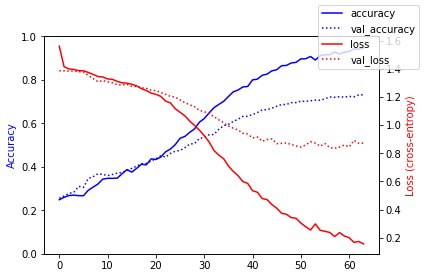

In [14]:
fig,ax=plt.subplots()
ax.plot(hist.history['accuracy'], color = 'b')
ax.plot(hist.history['val_accuracy'], linestyle=':', color = 'b')
ax.set_ylabel("Accuracy", color = 'b')
ax.set_ylim([0,1])
ax2=ax.twinx()
ax2.plot(hist.history['loss'],  color = 'r')
ax2.plot(hist.history['val_loss'], linestyle=':',  color = 'r')
ax2.set_ylabel("Loss (cross-entropy)",  color = 'r')
fig.legend(['accuracy','val_accuracy','loss','val_loss'])

## CNN autoencoder

Set up the CNN autoencoder <br>
set up decoder with transpose convolutional layers

Create an autoencoder for feature learning

In [15]:
latent_dim = 296

class MyEncoder(tf.keras.Model):
    """
    Based on Original HopeFullNet
    """
    def __init__(self, inp_shape = (640,2)):
        super(MyEncoder, self).__init__()
        self.inp_shape = inp_shape

        self.kernel_size_0 = 20
        self.kernel_size_1 = 6
        self.drop_rate = 0.5

        self.conv1 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding= "same",
                                            input_shape=self.inp_shape)
        self.batch_n_1 = tfp.bijectors.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding= "valid")
        self.batch_n_2 = tfp.bijectors.BatchNormalization()
        self.spatial_drop_1 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.conv3 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding= "valid")
        self.avg_pool1 = tf.keras.layers.AvgPool1D(pool_size=2)
        self.conv4 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding= "valid")
        self.spatial_drop_2 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.flat = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(296, activation='relu')

    def call(self, input_tensor):
        conv1 = self.conv1(input_tensor)
        batch_n_1 = self.batch_n_1(conv1)
        conv2 = self.conv2(batch_n_1)
        batch_n_2 = self.batch_n_2(conv2)
        spatial_drop_1 = self.spatial_drop_1(batch_n_2)
        conv3 = self.conv3(spatial_drop_1)
        avg_pool1 = self.avg_pool1(conv3)
        conv4 = self.conv4(avg_pool1)
        spatial_drop_2 = self.spatial_drop_2(conv4)
        flat = self.flat(spatial_drop_2)
        return self.out(flat)

class MyDecoder(tf.keras.Model):
    """
    Based on Original HopeFullNet
    """
    def __init__(self, inp_shape = (296,)):
        super(MyDecoder, self).__init__()
        self.inp_shape = inp_shape

        self.kernel_size_0 = 20
        self.kernel_size_1 = 6
        self.drop_rate = 0.5

        self.conv1 = tf.keras.layers.Conv1DTranspose(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding= "same",
                                            input_shape=self.inp_shape)
        self.batch_n_1 = tfp.bijectors.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1DTranspose(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding= "valid")
        self.batch_n_2 = tfp.bijectors.BatchNormalization()
        self.spatial_drop_1 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.conv3 = tf.keras.layers.Conv1DTranspose(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding= "valid")
        self.avg_pool1 = tf.keras.layers.AvgPool1D(pool_size=2)
        self.conv4 = tf.keras.layers.Conv1DTranspose(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding= "valid")
        self.spatial_drop_2 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.reshape1 = tf.keras.layers.Reshape((148,2))
        self.flat = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(296, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(self.drop_rate)
        self.dense2 = tf.keras.layers.Dense(148, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(self.drop_rate)
        self.out = tf.keras.layers.Dense(1280, activation='relu')
        self.reshape2 = tf.keras.layers.Reshape((640,2))

    def call(self, input_tensor):
        dense1 = self.dense1(input_tensor)
        flat = self.reshape1(dense1)
        spatial_drop_2 = self.spatial_drop_2(flat)
        conv4 = self.conv4(spatial_drop_2)
        avg_pool1 = self.avg_pool1(conv4)
        conv3 = self.conv3(avg_pool1)
        spatial_drop_1 = self.spatial_drop_1(conv3)
        batch_n_2 = self.batch_n_2(spatial_drop_1)
        conv2 = self.conv2(batch_n_2)
        batch_n_1 = self.batch_n_1(conv2)
        conv1 = self.conv1(batch_n_1)
        flat1 = self.flat(conv1)
        last = self.out(flat1)
        return self.reshape2(last)


class Autoencoder(tf.keras.models.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = MyEncoder()
    self.decoder = MyDecoder()

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

Compile the autoencoder

In [16]:
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

modelPath = filepath+'\\models\\autoencoderOnlineDataModel.h5'

# build callback list
checkpoint = ModelCheckpoint( # set model saving checkpoints
    modelPath, # set path to save model weights
    monitor='val_loss', # set monitor metrics
    verbose=1, # set training verbosity
    save_best_only=True, # set if want to save only best weights
    save_weights_only=True, # set if you want to save only model weights
    mode='auto', # set if save min or max in metrics
    save_freq='epoch' # interval between checkpoints
    )

earlystopping = EarlyStopping(
    monitor='val_loss', # set monitor metrics
    min_delta=0.00001, # set minimum metrics delta
    patience=10, # number of epochs to stop training
    restore_best_weights=True, # set if use best weights or last weights
    )
callbacksList = [checkpoint, earlystopping] # build callbacks list

Train the autoencoder

In [17]:
hist = autoencoder.fit(x_train_reshaped, x_train_reshaped,
                epochs=400, batch_size=10,
                shuffle=True,
                validation_data=(x_valid_reshaped, x_valid_reshaped),
                callbacks = callbacksList)

Epoch 1/400
389/389 [==============================] - ETA: 0s - loss: 0.0458
Epoch 1: val_loss improved from inf to 0.03810, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\models\autoencoderOnlineDataModel.h5
389/389 [==============================] - 21s 45ms/step - loss: 0.0458 - val_loss: 0.0381
Epoch 2/400
388/389 [============================>.] - ETA: 0s - loss: 0.0383
Epoch 2: val_loss improved from 0.03810 to 0.03780, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\models\autoencoderOnlineDataModel.h5
389/389 [==============================] - 16s 41ms/step - loss: 0.0383 - val_loss: 0.0378
Epoch 3/400
388/389 [============================>.] - ETA: 0s - loss: 0.0382
Epoch 3: val_loss improved from 0.03780 to 0.03728, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\models\autoencoderOnlineDataModel.h5
389/389 [==============================] - 16s 41ms/step - loss: 0.0382 - val_loss: 0.0373
Epoch 4/400
388/389 [====================

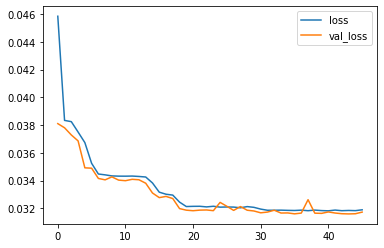

In [18]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])

In [19]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_encoder (MyEncoder)      multiple                  2904744   
                                                                 
 my_decoder (MyDecoder)      multiple                  4233064   
                                                                 
Total params: 7,137,808
Trainable params: 7,137,552
Non-trainable params: 256
_________________________________________________________________


## append an MLP to the trained encoder

(Brain Surgery) <br>

Clip off the encoder part of the neural network<br>
Freeze the lower convoluutional layers<br>

Connect to another couple of fully connected layers<br>
Only train those last few layers

In [20]:
autoencoder_loaded = tf.keras.models.load_model(filepath+'\\models\\autoencoderOnlineDataModel')

Freeze encoder and add an MLP to the output of the encoder in another network

In [21]:
NewNet = tf.keras.Sequential()
for layer in autoencoder_loaded.encoder.layers:
    layer.trainable = False
    NewNet.add(layer)
drop_rate = 0.5
NewNet.add(tf.keras.layers.Dropout(drop_rate))
NewNet.add(tf.keras.layers.Dense(148, activation='relu'))
NewNet.add(tf.keras.layers.Dropout(drop_rate))
NewNet.add(tf.keras.layers.Dense(74, activation='relu'))
NewNet.add(tf.keras.layers.Dropout(drop_rate))
NewNet.add(tf.keras.layers.Dense(4, activation='softmax'))

# check trainablitity

for layer in NewNet.layers:
    print(layer)
    print(layer.trainable)

NewNet.summary()


False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_68 (Conv1D)          (None, 640, 32)           1312      
                                                                 
 conv1d_69 (Conv1D)          (None, 621, 32)           20512     
                                                                 
 spatial_dropout1d_54 (Spati  (None, 621, 32)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_70 (Conv1D)          (None, 616, 32)           6176      
                                                                 
 average_pooling1d_27 (Avera  (None, 308, 32)          0         
 gePooling1D)                                                    
                                      

In [22]:
learning_rate = 1e-4

loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

NewNet.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# Where to save model
modelPath = filepath + r'\models\autoencoderMlpModel.h5'

# build callback list
checkpoint = ModelCheckpoint( # set model saving checkpoints
    modelPath, # set path to save model weights
    monitor='val_loss', # set monitor metrics
    verbose=1, # set training verbosity
    save_best_only=True, # set if want to save only best weights
    save_weights_only=True, # set if you want to save only model weights
    mode='auto', # set if save min or max in metrics
    save_freq='epoch' # interval between checkpoints
    )

earlystopping = EarlyStopping(
    monitor='val_loss', # set monitor metrics
    min_delta=0.00001, # set minimum metrics delta
    patience=6, # number of epochs to stop training
    restore_best_weights=True, # set if use best weights or last weights
    )
callbacksList = [checkpoint, earlystopping] # build callbacks list

In [23]:
hist = NewNet.fit(x_test_reshaped, y_test_OH, epochs=100, batch_size=10,
                    validation_data=(x_valid_reshaped, y_valid_OH), callbacks=callbacksList)

Epoch 1/100
453/454 [============================>.] - ETA: 0s - loss: 1.3872 - accuracy: 0.2481
Epoch 1: val_loss improved from inf to 1.38631, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\models\autoencoderMlpModel.h5
454/454 [==============================] - 10s 19ms/step - loss: 1.3872 - accuracy: 0.2482 - val_loss: 1.3863 - val_accuracy: 0.2498
Epoch 2/100
453/454 [============================>.] - ETA: 0s - loss: 1.3867 - accuracy: 0.2514
Epoch 2: val_loss improved from 1.38631 to 1.38630, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\models\autoencoderMlpModel.h5
454/454 [==============================] - 8s 19ms/step - loss: 1.3867 - accuracy: 0.2515 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 3/100
451/454 [============================>.] - ETA: 0s - loss: 1.3865 - accuracy: 0.2625
Epoch 3: val_loss did not improve from 1.38630
454/454 [==============================] - 8s 18ms/step - loss: 1.3865 - accuracy: 0.2632 - val_loss: 1.3863 - 

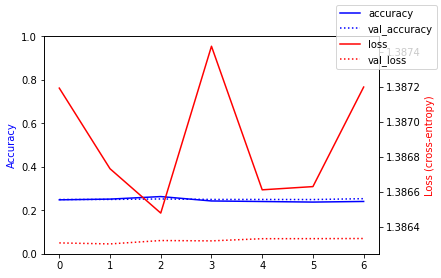

In [24]:
fig,ax=plt.subplots()
ax.plot(hist.history['accuracy'], color = 'b')
ax.plot(hist.history['val_accuracy'], linestyle=':', color = 'b')
ax.set_ylabel("Accuracy", color = 'b')
ax.set_ylim([0,1])
ax2=ax.twinx()
ax2.plot(hist.history['loss'],  color = 'r')
ax2.plot(hist.history['val_loss'], linestyle=':',  color = 'r')
ax2.set_ylabel("Loss (cross-entropy)",  color = 'r')
fig.legend(['accuracy','val_accuracy','loss','val_loss'])

## Transfer learning

In [25]:
trainedModel_loaded = tf.keras.models.load_model(filepath + '\\models\\roi_b')

Replace the output layer for 4 rather than 5 classes

In [26]:
trainedModel_newLayers = tf.keras.Sequential()
for layer in trainedModel_loaded.layers[:14]: # go through until flatten layer
    trainedModel_newLayers.add(layer)

trainedModel_newLayers.add(tf.keras.layers.Dense(74, activation='relu'))
trainedModel_newLayers.add(tf.keras.layers.Dropout(0.5))
trainedModel_newLayers.add(tf.keras.layers.Dense(4, activation='softmax'))

trainedModel_newLayers.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 640, 32)           1312      
                                                                 
 batch_normalization (BatchN  (None, 640, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 621, 32)           20512     
                                                                 
 batch_normalization_1 (Batc  (None, 621, 32)          128       
 hNormalization)                                                 
                                                                 
 spatial_dropout1d (SpatialD  (None, 621, 32)          0         
 ropout1D)                                                       
                                                      

Fine tune model (low learning rate)

In [27]:
learning_rate = 1e-6

loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
modelPath = os.path.join(os.getcwd(), 'tunedMode.h5')
print('Saving to: ' + modelPath)

trainedModel_newLayers.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

checkpoint = ModelCheckpoint( # set model saving checkpoints
    modelPath, # set path to save model weights
    monitor='val_loss', # set monitor metrics
    verbose=1, # set training verbosity
    save_best_only=True, # set if want to save only best weights
    save_weights_only=True, # set if you want to save only model weights
    mode='auto', # set if save min or max in metrics
    save_freq="epoch"  # interval between checkpoints
    )

earlystopping = EarlyStopping(
    monitor='val_loss', # set monitor metrics
    min_delta=0.00001, # set minimum metrics delta
    patience=4, # number of epochs to stop training
    restore_best_weights=True, # set if use best weights or last weights
    )
callbacksList = [checkpoint, earlystopping] # build callbacks list

hist = trainedModel_newLayers.fit(x_train_reshaped, y_train_OH_smote, epochs=50, batch_size=10,
                validation_data=(x_test_reshaped, y_test_OH), callbacks=callbacksList) #32

Saving to: c:\Users\james\OneDrive\GradSchool\Spring 2022\tunedMode.h5
Epoch 1/50
388/389 [============================>.] - ETA: 0s - loss: 2.6601 - accuracy: 0.2466
Epoch 1: val_loss improved from inf to 1.51835, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\tunedMode.h5
389/389 [==============================] - 25s 59ms/step - loss: 2.6581 - accuracy: 0.2469 - val_loss: 1.5184 - val_accuracy: 0.2498
Epoch 2/50
389/389 [==============================] - ETA: 0s - loss: 2.5868 - accuracy: 0.2477
Epoch 2: val_loss improved from 1.51835 to 1.49406, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\tunedMode.h5
389/389 [==============================] - 21s 55ms/step - loss: 2.5868 - accuracy: 0.2477 - val_loss: 1.4941 - val_accuracy: 0.2507
Epoch 3/50
388/389 [============================>.] - ETA: 0s - loss: 2.4423 - accuracy: 0.2606
Epoch 3: val_loss improved from 1.49406 to 1.47426, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\tunedMod

Freeze the first few convolutional layers

In [28]:
for i in range(10):
    trainedModel_newLayers.layers[i].trainable = False

for layer in trainedModel_newLayers.layers:
    print(layer)
    print('Trainable? ' + str(layer.trainable))

trainedModel_newLayers.summary()

Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? False
Trainable? True
Trainable? True
Trainable? True
Trainable? True
Trainable? True
Trainable? True
Trainable? True
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 640, 32)           1312      
                                                                 
 batch_normalization (BatchN  (None, 640, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 621, 32)           20512     
                                                                 
 batch_normalization_1 (Batc  (None, 621, 32)          128       
 hNormalization)                    

In [29]:
learning_rate = 1e-4

loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
modelPath = os.path.join(os.getcwd(), 'tunedMode.h5')
print('Saving to: ' + modelPath)

trainedModel_newLayers.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

checkpoint = ModelCheckpoint( # set model saving checkpoints
    modelPath, # set path to save model weights
    monitor='val_loss', # set monitor metrics
    verbose=1, # set training verbosity
    save_best_only=True, # set if want to save only best weights
    save_weights_only=True, # set if you want to save only model weights
    mode='auto', # set if save min or max in metrics
    save_freq="epoch"  # interval between checkpoints
    )

earlystopping = EarlyStopping(
    monitor='val_loss', # set monitor metrics
    min_delta=0.00001, # set minimum metrics delta
    patience=4, # number of epochs to stop training
    restore_best_weights=True, # set if use best weights or last weights
    )
callbacksList = [checkpoint, earlystopping] # build callbacks list

hist = trainedModel_newLayers.fit(x_train_reshaped, y_train_OH_smote, epochs=100, batch_size=10,
                validation_data=(x_test_reshaped, y_test_OH), callbacks=callbacksList) #32

Saving to: c:\Users\james\OneDrive\GradSchool\Spring 2022\tunedMode.h5
Epoch 1/100
387/389 [============================>.] - ETA: 0s - loss: 1.5296 - accuracy: 0.2558
Epoch 1: val_loss improved from inf to 1.39154, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\tunedMode.h5
389/389 [==============================] - 11s 24ms/step - loss: 1.5293 - accuracy: 0.2557 - val_loss: 1.3915 - val_accuracy: 0.2451
Epoch 2/100
386/389 [============================>.] - ETA: 0s - loss: 1.4626 - accuracy: 0.2466
Epoch 2: val_loss improved from 1.39154 to 1.38922, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\tunedMode.h5
389/389 [==============================] - 9s 23ms/step - loss: 1.4629 - accuracy: 0.2467 - val_loss: 1.3892 - val_accuracy: 0.2425
Epoch 3/100
389/389 [==============================] - ETA: 0s - loss: 1.4235 - accuracy: 0.2582
Epoch 3: val_loss improved from 1.38922 to 1.38820, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\tunedM

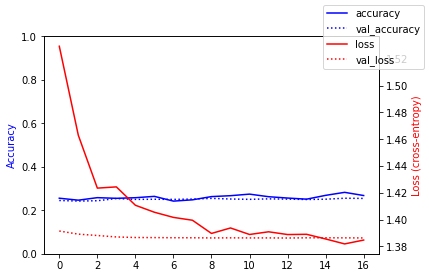

In [30]:
fig,ax=plt.subplots()
ax.plot(hist.history['accuracy'], color = 'b')
ax.plot(hist.history['val_accuracy'], linestyle=':', color = 'b')
ax.set_ylabel("Accuracy", color = 'b')
ax.set_ylim([0,1])
ax2=ax.twinx()
ax2.plot(hist.history['loss'],  color = 'r')
ax2.plot(hist.history['val_loss'], linestyle=':',  color = 'r')
ax2.set_ylabel("Loss (cross-entropy)",  color = 'r')
fig.legend(['accuracy','val_accuracy','loss','val_loss'])


Evaluate best (initial) model

142/142 [==============================] - 1s 10ms/step - loss: 0.8356 - accuracy: 0.7198

Accuracy: 0.7197971940040588

Loss:  0.835623025894165
142/142 [==============================] - 1s 6ms/step

 Cohen kappa 

 0.6263962375073486

 Classification report 

               precision    recall  f1-score   support

       Right       0.72      0.67      0.69      1134
        Left       0.68      0.78      0.73      1134
        Feet       0.73      0.70      0.72      1134
      tongue       0.75      0.73      0.74      1134

    accuracy                           0.72      4536
   macro avg       0.72      0.72      0.72      4536
weighted avg       0.72      0.72      0.72      4536


 Confusion matrix 

 [[758 146 106 124]
 [100 880  95  59]
 [ 88 161 798  87]
 [112 104  89 829]]


<AxesSubplot:>

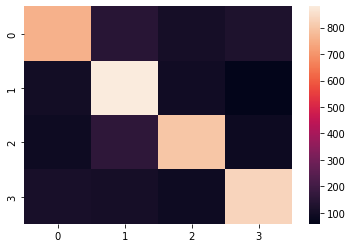

In [37]:
testLoss, testAcc = model.evaluate(x_valid_reshaped, y_valid_OH)
print('\nAccuracy:', testAcc)
print('\nLoss: ', testLoss)

from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
yPred = model.predict(x_valid_reshaped)

# convert from one hot encode in string
yTestClass = np.argmax(y_valid_OH, axis=1)
yPredClass = np.argmax(yPred,axis=1)

print('\n Cohen kappa \n\n',
  cohen_kappa_score(
      yTestClass,
      yPredClass
      )
  )

print('\n Classification report \n\n',
  classification_report(
      yTestClass,
      yPredClass,
       target_names=["Right", "Left", "Feet", "tongue"]
      )
  )

print('\n Confusion matrix \n\n',
  confusion_matrix(
      yTestClass,
      yPredClass,
      )
  )

import seaborn as sns
sns.heatmap(confusion_matrix(
      yTestClass,
      yPredClass,
      ))